# Setup

In [30]:
import sys
import os
# add parent directory (where "natsume" lives) to sys.path so I can import natsume
sys.path.append(r"C:\Users\WBS\Desktop\EXOPLANET WORK\006 NATSUME")
import natsume

import ttv_curvefit.curvefit as ttvfit  # custom-written
import ttvfast
from ttvfast import models

from tqdm import tqdm
import pandas as pd
import numpy as np
from scipy.stats import gmean
from astropy import units as u
from astropy.constants import M_earth
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import seaborn as sns

# Import CSV for fits
fits = pd.read_csv(r"C:\Users\WBS\Desktop\EXOPLANET WORK\006 NATSUME\validation\1st_order_TTVFast\lithwick_TTVFast_fits.csv")
total = len(fits)

R2_threshold = 0.5
R2_filter = (fits.R2_1 > R2_threshold) & (fits.R2_2 > R2_threshold)
fits = fits[R2_filter].reset_index()
good = len(fits)

print(f'Good systems: {good}/{total} ({(good/total) * 100:.2f}%)')

fits.head()

Good systems: 6035/20000 (30.18%)


,index,e1,w1,e2,w2,Delta,j,P1,P2,m1,...,V1,Pttv1,phase1,A2,B2,V2,Pttv2,phase2,R2_1,R2_2
0,0,0.053388,186.043895,0.076075,181.818531,0.222638,2,7,17.116927,12.834853,...,0.000006,39.170384,-0.075882,0.000005,1.366313e-08,0.000109,38.501193,6.101424,0.517626,0.973726
1,1,0.008526,112.339563,0.097244,295.435382,-0.019897,4,7,9.147629,2.805066,...,0.052942,171.464261,7.193759,0.013807,-6.882998e-05,0.023682,171.278223,10.324996,0.848293,0.849308
2,2,0.086694,341.863230,0.025745,345.114473,0.023387,2,7,14.327417,1.389300,...,0.003736,307.951132,5.013612,-0.000163,4.146063e-07,0.002611,307.968031,1.847399,0.999217,0.999008
3,3,0.002025,270.899942,0.005079,34.752301,-0.026923,3,7,10.217306,108.143864,...,0.000561,136.220832,4.553395,0.007432,-5.665574e-05,0.089183,135.762274,1.387800,0.964035,0.985141
4,7,0.004935,311.271768,0.039610,285.653471,0.018964,4,7,9.510328,40.595846,...,0.002537,132.674883,3.109021,-0.004966,7.073116e-06,0.037382,132.497581,6.266347,0.933620,0.925571


In [71]:
# Functions, returns in %
def err_gmean(calc, sol):
    nonan = ~np.isnan(calc) & ~np.isnan(sol) & (calc/sol < 1e+3) & (calc/sol > 1e-3) 
    relerrs = calc[nonan]/sol[nonan]
    
    gavg = gmean(relerrs)
    return (gavg - 1) * 100

def err_med(calc, sol):
    nonan = ~np.isnan(calc) & ~np.isnan(sol) & (calc/sol < 1e+3) & (calc/sol > 1e-3) 
    relerrs = calc[nonan]/sol[nonan]
    
    gavg = np.median(relerrs)
    return (gavg - 1) * 100

def err_gstd(calc, sol):
    nonan = ~np.isnan(calc) & ~np.isnan(sol) & (calc/sol < 1e+3) & (calc/sol > 1e-3) 
    relerrs = calc[nonan]/sol[nonan]
    
    logs = np.log(relerrs)
    gstd = np.exp(logs.std(ddof=0))
    return gstd * 100

def returnMetrics(df, mask='all'):
    if isinstance(mask, str):
        if (mask == 'all'):
            m = np.ones(len(df), dtype=bool)
    else:
        m = mask
        
    err1 = err_gmean(df['m_calc_in'][m], df['m1'][m])
    err2 = err_gmean(df['m_calc_out'][m], df['m2'][m])
    med1 = err_med(df['m_calc_in'][m], df['m1'][m])
    med2 = err_med(df['m_calc_out'][m], df['m2'][m])
    gstd1 = err_gstd(df['m_calc_in'][m], df['m1'][m])
    gstd2 = err_gstd(df['m_calc_out'][m], df['m2'][m])

    return err1, err2, med1, med2, gstd1, gstd2

# Non-nominal validation

In [72]:
# Naive validation
j = fits['j']; mmr = j.apply(lambda x: f"{int(x)}:{int(x)-1}")
P_in = fits['P1']; P_out = fits['P2']
PTTV_in = fits['Pttv1']; PTTV_out = fits['Pttv2']
V_in = np.abs(fits['V1']); V_out = np.abs(fits['V2'])
Mstar = 1

e1 = fits['e1']; w1 = fits['w1']
e2 = fits['e2']; w2 = fits['w2']
z = [natsume.get_ComplexEccentricities(e1[i], w1[i], e2[i], w2[i]) for i in range(len(e1))]

mu_in_sol = (fits['m1'].values * M_earth).to(Mstar*u.M_sun).value
mu_out_sol = (fits['m2'].values * M_earth).to(Mstar*u.M_sun).value

# Extract mu_out and mu_in
mcalc_out, mcalc_in = np.array([]), np.array([])
mbad_out, mbad_in = np.array([]), np.array([])

for i in tqdm(range(len(mmr))):
    if max(PTTV_in[i]/PTTV_out[i], PTTV_out[i]/PTTV_in[i]) > 1.05: # Obviously unrealistic
        mcalc_in = np.append(mcalc_in, np.nan)
        mcalc_out = np.append(mcalc_out, np.nan)
        mbad_in = np.append(mbad_in, np.nan)
        mbad_out = np.append(mbad_out, np.nan)
        continue
    
    TTV_in = natsume.get_TTVSineCurve(amplitude=V_in[i], superperiod=PTTV_in[i])
    TTV_out = natsume.get_TTVSineCurve(amplitude=V_out[i], superperiod=PTTV_out[i])

    mu_in = natsume.EstimateInnerMass(outerTTV=TTV_out, outer_period=P_out[i], mmr=mmr[i], eccentricity=z[i])
    mu_out = natsume.EstimateOuterMass(innerTTV=TTV_in, inner_period=P_in[i], mmr=mmr[i], eccentricity=z[i])

    mu_in_expected = natsume.EstimateInnerMass(outerTTV=TTV_out, outer_period=P_out[i], mmr=mmr[i],
                                               eccentricity=z[i], inner_period=P_in[i])
    mu_out_expected = natsume.EstimateOuterMass(innerTTV=TTV_in, inner_period=P_in[i], mmr=mmr[i],
                                                eccentricity=z[i], outer_period=P_out[i])

    mu_in_closest = mu_in[np.argmin(np.abs(mu_in - mu_in_expected))]
    mu_out_closest =  mu_out[np.argmin(np.abs(mu_out - mu_out_expected))]    
    m_in = (mu_in_closest * Mstar*u.M_sun).to(u.M_earth).value
    m_out = (mu_out_closest * Mstar*u.M_sun).to(u.M_earth).value

    mcalc_in = np.append(mcalc_in, m_in)
    mcalc_out = np.append(mcalc_out, m_out)

    mu_in_bad = mu_in[np.argmax(np.abs(mu_in - mu_in_expected))]
    mu_out_bad =  mu_out[np.argmax(np.abs(mu_out - mu_out_expected))]    
    m_in_bad = (mu_in_bad * Mstar*u.M_sun).to(u.M_earth).value
    m_out_bad = (mu_out_bad * Mstar*u.M_sun).to(u.M_earth).value

    mbad_in = np.append(mbad_in, m_in_bad)
    mbad_out = np.append(mbad_out, m_out_bad)

compare = fits.copy()
compare['m_calc_in'] = mcalc_in
compare['m_calc_out'] = mcalc_out
compare['m_bad_in'] = mbad_in
compare['m_bad_out'] = mbad_out
compare.head()

100%|██████████████████████████████████████████████████████████████████████████████| 6035/6035 [01:08<00:00, 88.50it/s]


,index,e1,w1,e2,w2,Delta,j,P1,P2,m1,...,B2,V2,Pttv2,phase2,R2_1,R2_2,m_calc_in,m_calc_out,m_bad_in,m_bad_out
0,0,0.053388,186.043895,0.076075,181.818531,0.222638,2,7,17.116927,12.834853,...,1.366313e-08,0.000109,38.501193,6.101424,0.517626,0.973726,18.858816,0.489666,2.328490,0.106850
1,1,0.008526,112.339563,0.097244,295.435382,-0.019897,4,7,9.147629,2.805066,...,-6.882998e-05,0.023682,171.278223,10.324996,0.848293,0.849308,4.068498,11.505805,3.430549,9.248735
2,2,0.086694,341.863230,0.025745,345.114473,0.023387,2,7,14.327417,1.389300,...,4.146063e-07,0.002611,307.968031,1.847399,0.999217,0.999008,1.451184,3.014114,1.552207,3.731831
3,3,0.002025,270.899942,0.005079,34.752301,-0.026923,3,7,10.217306,108.143864,...,-5.665574e-05,0.089183,135.762274,1.387800,0.964035,0.985141,203.392358,1.872440,367.095115,3.992822
4,7,0.004935,311.271768,0.039610,285.653471,0.018964,4,7,9.510328,40.595846,...,7.073116e-06,0.037382,132.497581,6.266347,0.933620,0.925571,32.549227,2.725843,25.060855,1.996953


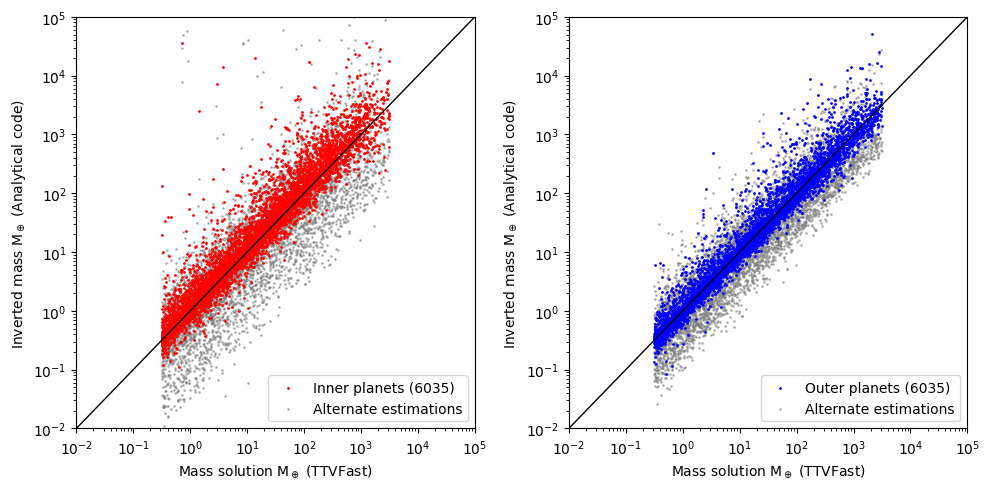

In [74]:
# Graph compare N-body outputs
fig, ax = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns
s = 1
minval = 1e-2
maxval = 1e+5
scatterCount = len(compare['m1'])

# Inner planets
ax[0].scatter(compare['m1'], compare['m_calc_in'], s=s, color='red', label=f'Inner planets ({scatterCount})', zorder=0)
ax[0].scatter(compare['m1'], compare['m_bad_in'], s=s, color='grey', label='Alternate estimations', zorder=-1, alpha=0.5)
ax[0].plot([minval, maxval], [minval, maxval], color='black', lw=1, zorder=1)
ax[0].set_xscale('log'); ax[0].set_yscale('log')
ax[0].set_xlim(minval, maxval); ax[0].set_ylim(minval, maxval)
ax[0].set_xlabel('Mass solution M$_\oplus$ (TTVFast)')
ax[0].set_ylabel('Inverted mass M$_\oplus$ (Analytical code)')
ax[0].legend(loc='lower right')

# Outer planets
ax[1].scatter(compare['m2'], compare['m_calc_out'], s=s, color='blue', label=f'Outer planets ({scatterCount})', zorder=0)
ax[1].scatter(compare['m2'], compare['m_bad_out'], s=s, color='grey', label='Alternate estimations', zorder=-1, alpha=0.5)
ax[1].plot([minval, maxval], [minval, maxval], color='black', lw=1, zorder=1)
ax[1].set_xscale('log'); ax[1].set_yscale('log')
ax[1].set_xlim(minval, maxval); ax[1].set_ylim(minval, maxval)
ax[1].set_xlabel('Mass solution M$_\oplus$ (TTVFast)')
ax[1].set_ylabel('Inverted mass M$_\oplus$ (Analytical code)')
ax[1].legend(loc='lower right')

fig.tight_layout()
plt.show()

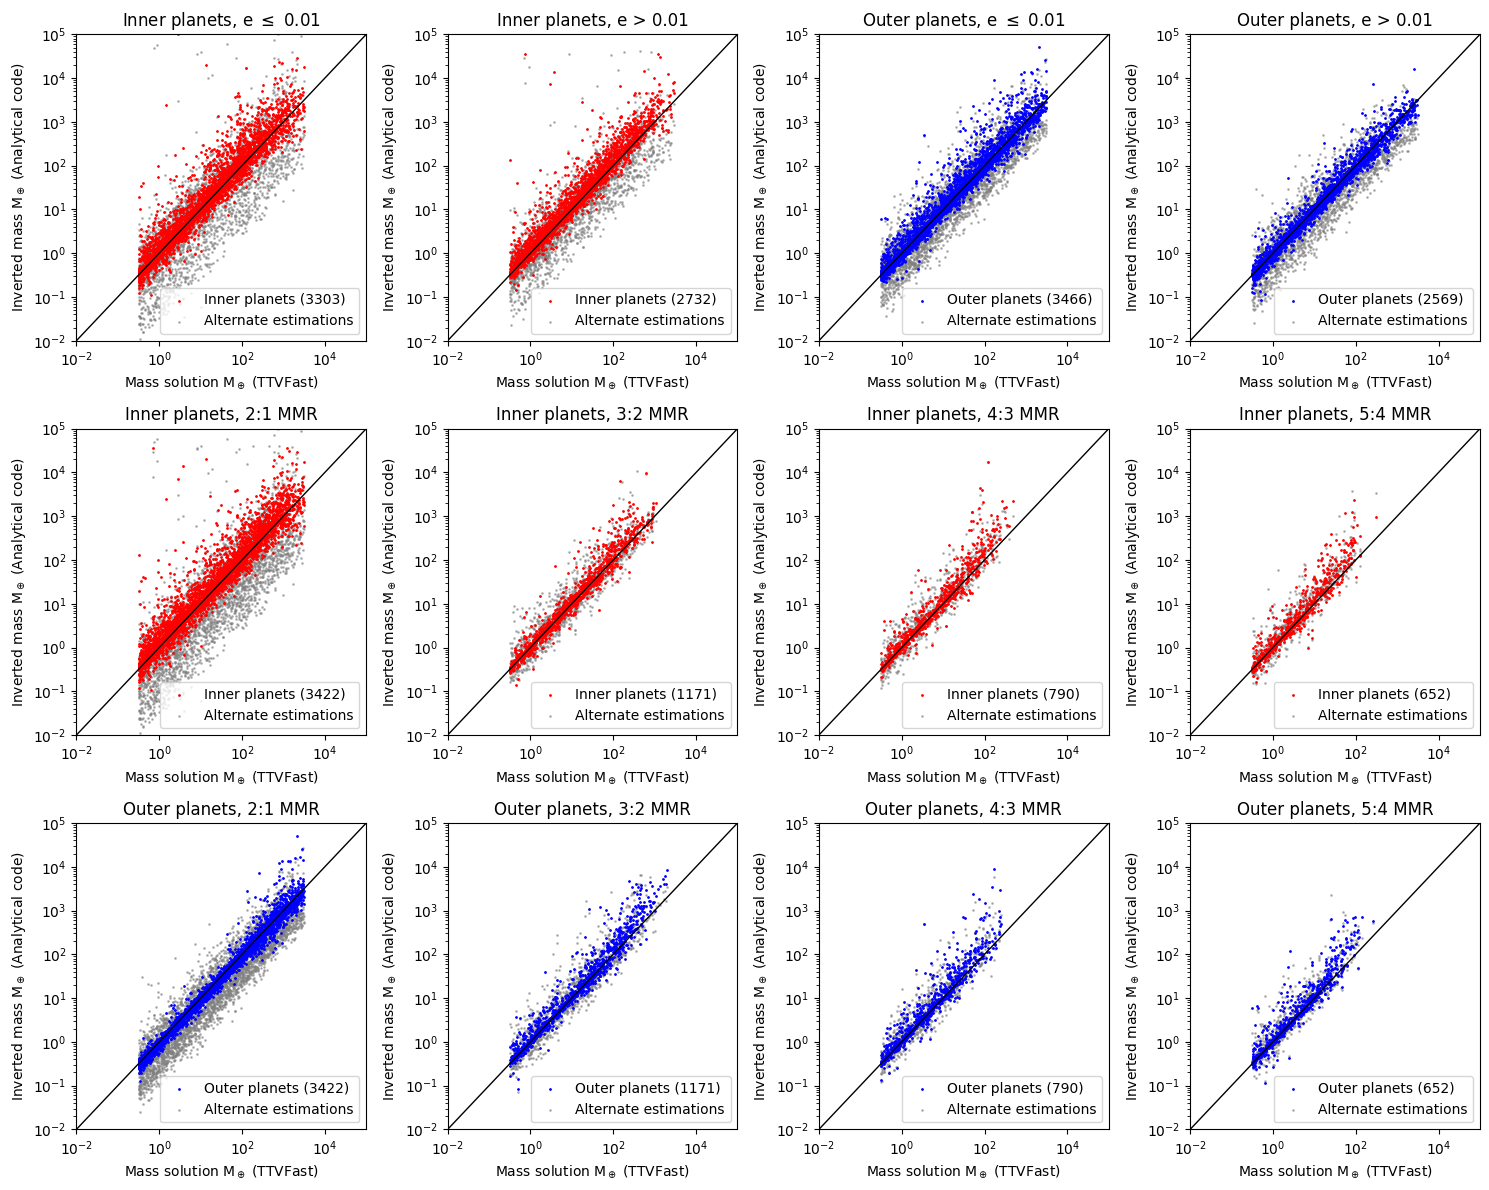

In [75]:
# Divide up by eccentricity and MMR
# Graph compare N-body outputs
fig, ax = plt.subplots(3, 4, figsize=(15, 12))

def plotMassEstimation(posTuple, x, ygood, ybad, color, innerouterStr, mask, regimeName):
    s = 1
    minval = 1e-2
    maxval = 1e+5
    scatterCount = len(x[mask])
    
    ax[posTuple].scatter(x[mask], ygood[mask], s=s, color=color, label=f'{innerouterStr} planets ({scatterCount})', zorder=0)
    ax[posTuple].scatter(x[mask], ybad[mask], s=s, color='grey', label='Alternate estimations', zorder=-1, alpha=0.5)
    ax[posTuple].plot([minval, maxval], [minval, maxval], color='black', lw=1, zorder=1)
    ax[posTuple].set_xscale('log'); ax[posTuple].set_yscale('log')
    ax[posTuple].set_xlim(minval, maxval); ax[posTuple].set_ylim(minval, maxval)
    ax[posTuple].set_xlabel('Mass solution M$_\oplus$ (TTVFast)')
    ax[posTuple].set_ylabel('Inverted mass M$_\oplus$ (Analytical code)')
    ax[posTuple].legend(loc='lower right')
    ax[posTuple].set_title(f'{innerouterStr} planets, {regimeName}')

def plotMassWithRegimes(df):
    # Regime definitions
    ethres = 0.01
    lowe1 = (compare.e1 <= ethres); highe1 = (compare.e1 > ethres)
    lowe2 = (compare.e2 <= ethres); highe2 = (compare.e2 > ethres)
    def jmask(n): 
        return (compare.j == n)
    
    # Eccentricity
    plotMassEstimation((0,0), df['m1'], df['m_calc_in'], df['m_bad_in'], 'red', 'Inner', lowe1, 'e $\leq$ 0.01')
    plotMassEstimation((0,1), df['m1'], df['m_calc_in'], df['m_bad_in'], 'red', 'Inner', highe1, 'e > 0.01')
    plotMassEstimation((0,2), df['m2'], df['m_calc_out'], df['m_bad_out'], 'blue', 'Outer', lowe2, 'e $\leq$ 0.01')
    plotMassEstimation((0,3), df['m2'], df['m_calc_out'], df['m_bad_out'], 'blue', 'Outer', highe2, 'e > 0.01')
    
    # MMR
    plotMassEstimation((1,0), df['m1'], df['m_calc_in'], df['m_bad_in'], 'red', 'Inner', jmask(2), '2:1 MMR')
    plotMassEstimation((1,1), df['m1'], df['m_calc_in'], df['m_bad_in'], 'red', 'Inner', jmask(3), '3:2 MMR')
    plotMassEstimation((1,2), df['m1'], df['m_calc_in'], df['m_bad_in'], 'red', 'Inner', jmask(4), '4:3 MMR')
    plotMassEstimation((1,3), df['m1'], df['m_calc_in'], df['m_bad_in'], 'red', 'Inner', jmask(5), '5:4 MMR')
    
    plotMassEstimation((2,0), df['m2'], df['m_calc_out'], df['m_bad_out'], 'blue', 'Outer', jmask(2), '2:1 MMR')
    plotMassEstimation((2,1), df['m2'], df['m_calc_out'], df['m_bad_out'], 'blue', 'Outer', jmask(3), '3:2 MMR')
    plotMassEstimation((2,2), df['m2'], df['m_calc_out'], df['m_bad_out'], 'blue', 'Outer', jmask(4), '4:3 MMR')
    plotMassEstimation((2,3), df['m2'], df['m_calc_out'], df['m_bad_out'], 'blue', 'Outer', jmask(5), '5:4 MMR')

plotMassWithRegimes(compare)

fig.tight_layout()
plt.show()

In [77]:
# Relative bias and average error
err1, err2, med1, med2, gstd1, gstd2 = returnMetrics(compare, mask='all')

print(f'Geometric mean error, median error, and geometric STD (Inner): {err1:.2f}%, {med1:.2f}%, {gstd1:.2f}%')
print(f'Geometric mean error, median error, and geometric STD (Outer): {err2:.2f}%, {med2:.2f}%, {gstd2:.2f}%')

Geometric mean error, median error, and geometric STD (Inner): 34.99%, 16.15%, 199.85%
Geometric mean error, median error, and geometric STD (Outer): 10.35%, 1.29%, 163.53%


# Nominal validation

In [78]:
# Naive nominal mass validation
j = fits['j']; mmr = j.apply(lambda x: f"{int(x)}:{int(x)-1}")
P_in = fits['P1']; P_out = fits['P2']
PTTV_in = fits['Pttv1']; PTTV_out = fits['Pttv2']
V_in = np.abs(fits['V1']); V_out = np.abs(fits['V2'])
Mstar = 1

e1 = fits['e1']; w1 = fits['w1']
e2 = fits['e2']; w2 = fits['w2']
z = [natsume.get_ComplexEccentricities() for i in range(len(e1))]

mu_in_sol = (fits['m1'].values * M_earth).to(Mstar*u.M_sun).value
mu_out_sol = (fits['m2'].values * M_earth).to(Mstar*u.M_sun).value

# Extract mu_out and mu_in
mcalc_out, mcalc_in = np.array([]), np.array([])
mbad_out, mbad_in = np.array([]), np.array([])
for i in tqdm(range(len(mmr))):
    if max(PTTV_in[i]/PTTV_out[i], PTTV_out[i]/PTTV_in[i]) > 1.05: # Obviously unrealistic
        mcalc_in = np.append(mcalc_in, np.nan)
        mcalc_out = np.append(mcalc_out, np.nan)
        mbad_in = np.append(mbad_in, np.nan)
        mbad_out = np.append(mbad_out, np.nan)
        continue
    
    TTV_in = natsume.get_TTVSineCurve(amplitude=V_in[i], superperiod=PTTV_in[i])
    TTV_out = natsume.get_TTVSineCurve(amplitude=V_out[i], superperiod=PTTV_out[i])

    mu_in = natsume.EstimateInnerMass(outerTTV=TTV_out, outer_period=P_out[i], mmr=mmr[i], eccentricity=z[i])
    mu_out = natsume.EstimateOuterMass(innerTTV=TTV_in, inner_period=P_in[i], mmr=mmr[i], eccentricity=z[i])

    mu_in_expected = natsume.EstimateInnerMass(outerTTV=TTV_out, outer_period=P_out[i], mmr=mmr[i],
                                               eccentricity=z[i], inner_period=P_in[i])
    mu_out_expected = natsume.EstimateOuterMass(innerTTV=TTV_in, inner_period=P_in[i], mmr=mmr[i],
                                                eccentricity=z[i], outer_period=P_out[i])

    mu_in_closest = mu_in[np.argmin(np.abs(mu_in - mu_in_expected))]
    mu_out_closest =  mu_out[np.argmin(np.abs(mu_out - mu_out_expected))]    
    m_in = (mu_in_closest * Mstar*u.M_sun).to(u.M_earth).value
    m_out = (mu_out_closest * Mstar*u.M_sun).to(u.M_earth).value

    mcalc_in = np.append(mcalc_in, m_in)
    mcalc_out = np.append(mcalc_out, m_out)

    mu_in_bad = mu_in[np.argmax(np.abs(mu_in - mu_in_expected))]
    mu_out_bad =  mu_out[np.argmax(np.abs(mu_out - mu_out_expected))]    
    m_in_bad = (mu_in_bad * Mstar*u.M_sun).to(u.M_earth).value
    m_out_bad = (mu_out_bad * Mstar*u.M_sun).to(u.M_earth).value

    mbad_in = np.append(mbad_in, m_in_bad)
    mbad_out = np.append(mbad_out, m_out_bad)

compare_n = fits.copy()
compare_n['m_calc_in'] = mcalc_in
compare_n['m_calc_out'] = mcalc_out
compare_n['m_bad_in'] = mbad_in
compare_n['m_bad_out'] = mbad_out
compare_n.head()

100%|██████████████████████████████████████████████████████████████████████████████| 6035/6035 [01:06<00:00, 90.14it/s]


,index,e1,w1,e2,w2,Delta,j,P1,P2,m1,...,B2,V2,Pttv2,phase2,R2_1,R2_2,m_calc_in,m_calc_out,m_bad_in,m_bad_out
0,0,0.053388,186.043895,0.076075,181.818531,0.222638,2,7,17.116927,12.834853,...,1.366313e-08,0.000109,38.501193,6.101424,0.517626,0.973726,30.647408,0.341930,2.592379,0.122241
1,1,0.008526,112.339563,0.097244,295.435382,-0.019897,4,7,9.147629,2.805066,...,-6.882998e-05,0.023682,171.278223,10.324996,0.848293,0.849308,46.197942,148.002791,41.918122,128.139379
2,2,0.086694,341.863230,0.025745,345.114473,0.023387,2,7,14.327417,1.389300,...,4.146063e-07,0.002611,307.968031,1.847399,0.999217,0.999008,23.132700,18.057662,18.591473,15.866187
3,3,0.002025,270.899942,0.005079,34.752301,-0.026923,3,7,10.217306,108.143864,...,-5.665574e-05,0.089183,135.762274,1.387800,0.964035,0.985141,293.337657,2.510686,259.843684,3.094750
4,7,0.004935,311.271768,0.039610,285.653471,0.018964,4,7,9.510328,40.595846,...,7.073116e-06,0.037382,132.497581,6.266347,0.933620,0.925571,95.783951,9.360438,84.046234,7.769568


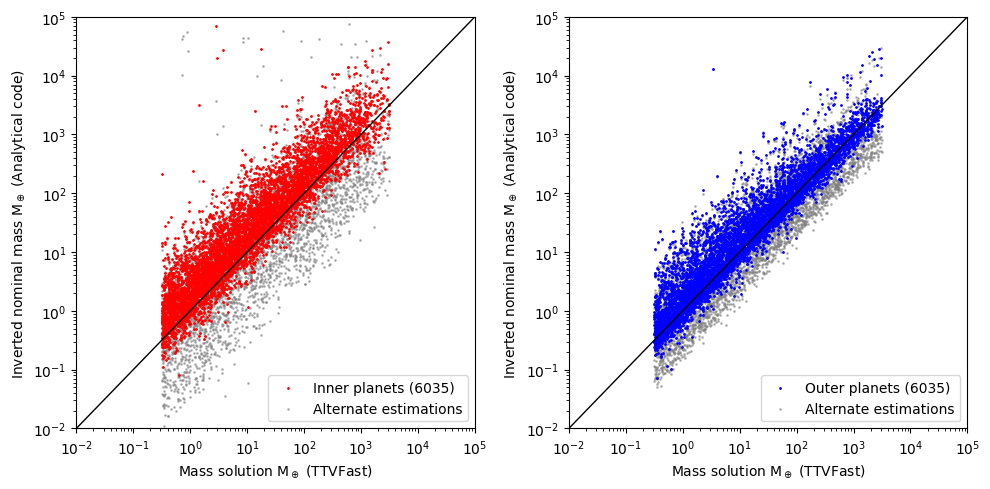

In [79]:
# Graph compare N-body outputs
fig, ax = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns
s = 1
minval = 1e-2
maxval = 1e+5

scatterCount = len(compare_n['m1'])

# Inner planets
ax[0].scatter(compare_n['m1'], compare_n['m_calc_in'], s=s, color='red', label=f'Inner planets ({scatterCount})', zorder=0)
ax[0].scatter(compare_n['m1'], compare_n['m_bad_in'], s=s, color='grey', label='Alternate estimations', zorder=-1, alpha=0.5)
ax[0].plot([minval, maxval], [minval, maxval], color='black', lw=1, zorder=1)
ax[0].set_xscale('log'); ax[0].set_yscale('log')
ax[0].set_xlim(minval, maxval); ax[0].set_ylim(minval, maxval)
ax[0].set_xlabel('Mass solution M$_\oplus$ (TTVFast)')
ax[0].set_ylabel('Inverted nominal mass M$_\oplus$ (Analytical code)')
ax[0].legend(loc='lower right')

# Outer planets
ax[1].scatter(compare_n['m2'], compare_n['m_calc_out'], s=s, color='blue', label=f'Outer planets ({scatterCount})', zorder=0)
ax[1].scatter(compare_n['m2'], compare_n['m_bad_out'], s=s, color='grey', label='Alternate estimations', zorder=-1, alpha=0.5)
ax[1].plot([minval, maxval], [minval, maxval], color='black', lw=1, zorder=1)
ax[1].set_xscale('log'); ax[1].set_yscale('log')
ax[1].set_xlim(minval, maxval); ax[1].set_ylim(minval, maxval)
ax[1].set_xlabel('Mass solution M$_\oplus$ (TTVFast)')
ax[1].set_ylabel('Inverted nominal mass M$_\oplus$ (Analytical code)')
ax[1].legend(loc='lower right')

fig.tight_layout()
plt.show()

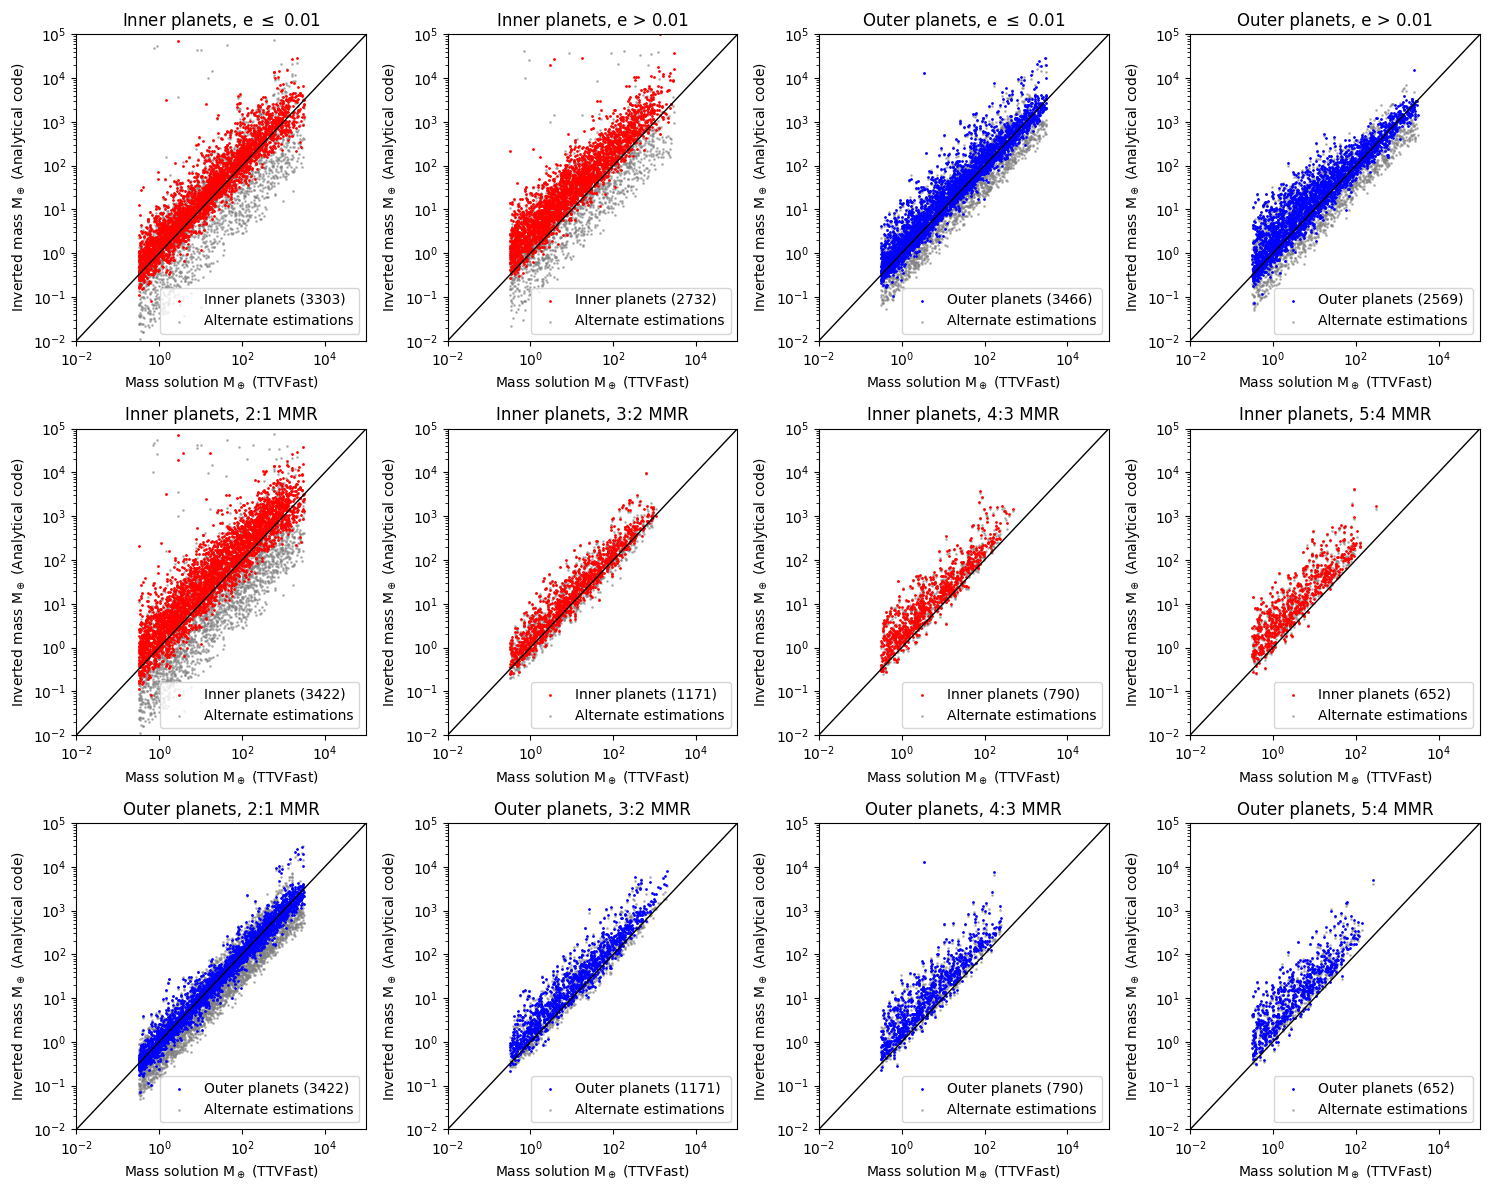

In [80]:
# Divide by regimes
fig, ax = plt.subplots(3, 4, figsize=(15, 12))
plotMassWithRegimes(compare_n)
fig.tight_layout()
plt.show()

In [82]:
# Relative bias and average error
err1, err2, med1, med2, gstd1, gstd2 = returnMetrics(compare_n, mask='all')

print(f'Geometric mean error, median error, and geometric STD (Inner): {err1:.2f}%, {med1:.2f}%, {gstd1:.2f}%')
print(f'Geometric mean error, median error, and geometric STD (Outer): {err2:.2f}%, {med2:.2f}%, {gstd2:.2f}%')

Geometric mean error, median error, and geometric STD (Inner): 118.06%, 92.59%, 241.20%
Geometric mean error, median error, and geometric STD (Outer): 51.97%, 27.45%, 212.18%


# Metric compilation

In [83]:
# Metric summarized in dataframe
metricCols = ['regime', 'count', 'GMerr', 'GMerr_n', 'MedErr', 'MedErr_n', 'GSTDerr', 'GSTDerr_n']
metrics = pd.DataFrame(columns=metricCols)
metrics.regime = ['Inner (Overall)', 'Inner (e = 0.001-0.01)', 'Inner (e = 0.01-0.1)',
                  'Inner (2:1 MMR)', 'Inner (3:2 MMR)', 'Inner (4:3 MMR)', 'Inner (5:4 MMR)',
                  'Outer (Overall)', 'Outer (e = 0.001-0.01)', 'Outer (e = 0.01-0.1)',
                  'Outer (2:1 MMR)', 'Outer (3:2 MMR)', 'Outer (4:3 MMR)', 'Outer (5:4 MMR)']
metrics.head()

,regime,count,GMerr,GMerr_n,MedErr,MedErr_n,GSTDerr,GSTDerr_n
0,Inner (Overall),NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Inner (e = 0.001-0.01),NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Inner (e = 0.01-0.1),NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Inner (2:1 MMR),NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Inner (3:2 MMR),NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [84]:
# Regime definitions
ethres = 0.01
lowe1 = (compare.e1 <= ethres); highe1 = (compare.e1 > ethres)
lowe2 = (compare.e2 <= ethres); highe2 = (compare.e2 > ethres)
def jmask(n): 
    return (compare.j == n)

# Create values to insert
def createListToInsert(innerOuterStr, m):
    err1, err2, med1, med2, gstd1, gstd2 = returnMetrics(compare, mask=m)
    err1n, err2n, med1n, med2n, gstd1n, gstd2n = returnMetrics(compare_n, mask=m)

    if innerOuterStr == 'Inner':
        metrics = [err1, err1n, med1, med1n, gstd1, gstd1n]
    elif innerOuterStr == 'Outer':
        metrics = [err2, err2n, med2, med2n, gstd2, gstd2n]

    count = len(compare.m1) if (isinstance(m, str) == True) else len(compare.m1[m])
    return [count, *metrics]

rows = []
for io in ['Inner', 'Outer']:
    for regime in ['all', 'lowe', 'highe', *[jmask(n) for n in range(2,6)]]:
        r = regime
        if isinstance(r, str):
            r = lowe1 if (regime == 'lowe') and (io == 'Inner') else r
            r = lowe2 if (regime == 'lowe') and (io == 'Outer') else r
            r = highe1 if (regime == 'highe') and (io == 'Inner') else r
            r = highe2 if (regime == 'highe') and (io == 'Outer') else r
        rowi = createListToInsert(io, m=r)
        rows.append(rowi)

# Inserting time
for i, r in enumerate(rows):
    metrics.loc[i, metricCols[1:]] = r

metrics

,regime,count,GMerr,GMerr_n,MedErr,MedErr_n,GSTDerr,GSTDerr_n
0,Inner (Overall),6035,34.992601,118.062241,16.154451,92.590664,199.849814,241.203871
1,Inner (e = 0.001-0.01),3303,32.905594,63.068839,14.725802,47.466561,212.495277,223.172964
2,Inner (e = 0.01-0.1),2732,37.532377,208.799323,18.011634,184.193639,184.123301,232.195272
3,Inner (2:1 MMR),3422,41.447077,115.864784,24.234595,92.496341,215.941656,263.896635
4,Inner (3:2 MMR),1171,18.647553,68.276916,8.147815,48.614401,165.776705,186.518386
5,Inner (4:3 MMR),790,34.724219,143.748983,12.445931,108.06342,188.700172,207.934448
6,Inner (5:4 MMR),652,34.27927,220.053935,12.069672,164.416605,180.967398,220.220888
7,Outer (Overall),6035,10.346039,51.973888,1.287039,27.448091,163.534125,212.176515
8,Outer (e = 0.001-0.01),3466,14.930894,43.635239,1.875485,22.817651,172.413745,201.674517
9,Outer (e = 0.01-0.1),2569,4.457994,63.97273,0.533244,38.430441,149.712517,224.664465


In [85]:
# Export metrics
metrics.to_csv('lithwick_code_metrics.csv', index=False)

In [114]:
# Plot visualization
inner = metrics[0:7]; outer = metrics[7:14]

def metricPlots(df, innerOuterStr):
    regimenames = ['Overall', 'low e', 'high e', '2:1', '3:2', '4:3', '5:4']
    colnames = ['Regime', 'Count', 'Geometric Mean Error [%]', 'Geometric Mean Error (Nominal) [%]',
                'Median Error [%]', 'Median Error (Nominal) [%]', 'Geometric STD Error [%]', 'Geometric STD Error (Nominal) [%]']
    axposes = [(n,m) for n in range(3) for m in range(2)]
    
    df.loc[:, 'regime'] = regimenames
    df.columns = colnames
    
    fig, ax = plt.subplots(3, 2, figsize=(10, 12))
    x = 'Regime'
    colors = ['black', *['seagreen'] * 2, *['darkorange'] * 4]
    
    for col, axpos in zip(colnames[2:8], axposes):    
        barplot = sns.barplot(data=df, x=x, y=col, ax=ax[axpos])
        ax[axpos].axhline(0, color='black', linestyle='-', linewidth=0.5)
        # ax[axpos].axhline(10, color='red', linestyle='--')
        # ax[axpos].axhline(100, color='red', linestyle='-')

        ys = []
        for patch, color in zip(barplot.patches, colors):
            patch.set_facecolor(color)
            height = patch.get_height()
            ys.append(height)
            
            ax[axpos].text(
                x=patch.get_x() + patch.get_width()/2,  # center of the bar
                y=height * 1.01,           # slightly above bar
                s=f'{height:.1f}',         # text to display
                ha='center', va='bottom'
            )
            
        ax[axpos].set_ylim(min(0, min(ys) * 1.1), max(ys) * 1.1)
        ax[axpos].set_xlabel(f'Regime ({innerOuterStr} planets)')
        
    plt.show()

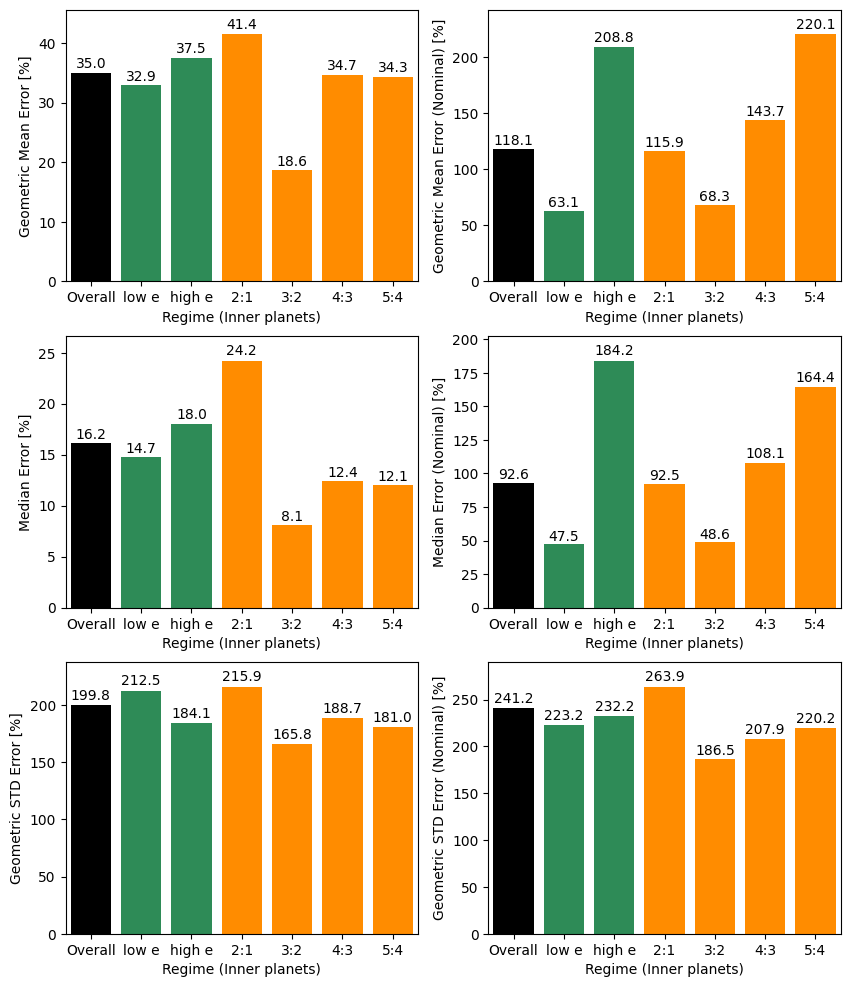

In [115]:
metricPlots(inner, 'Inner')

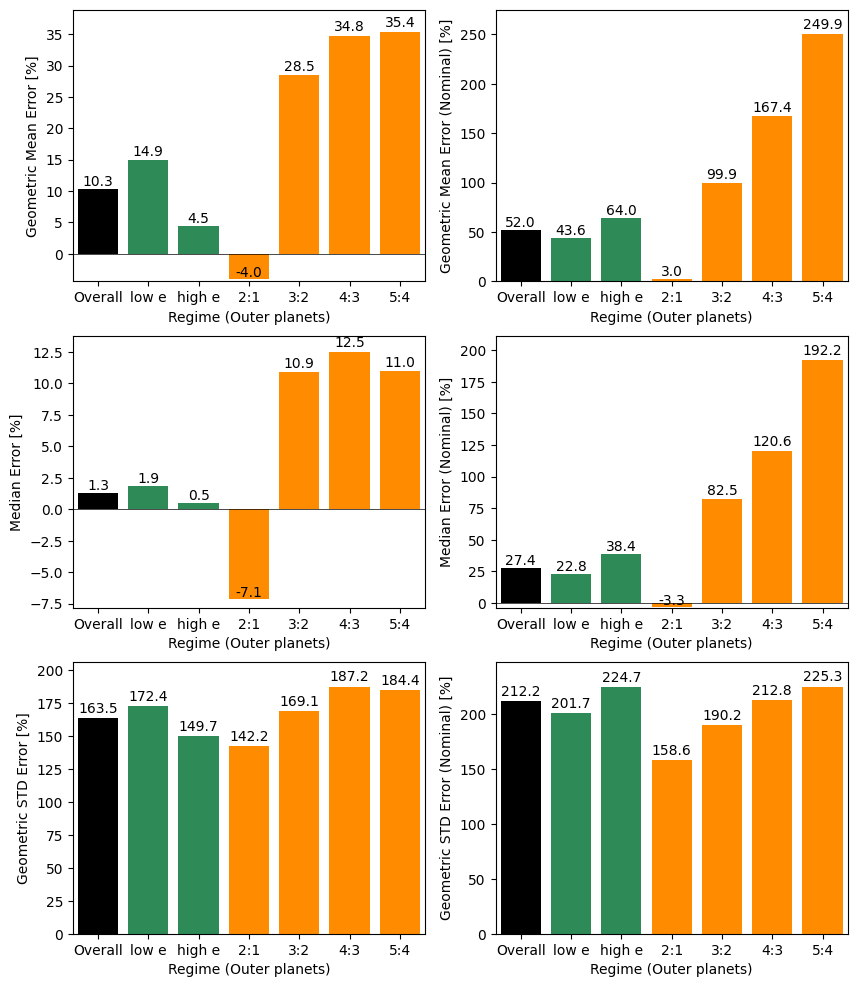

In [116]:
metricPlots(outer, 'Outer')